In [1]:
%matplotlib notebook

import datetime
import random
#import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6.0, 4.0)

import load_hats

start_day, end_day = '2016-04-01', '2018-05-31'

In [2]:
def read_met(site, yyyy):
    met_ftp = f'/aftp/met/{site}/'
    met_file = f'met_{site}_insitu_1_obop_hour_{yyyy}.txt'
    df = pd.read_csv(met_ftp+met_file, 
                delim_whitespace=True,
                names=['site','year','month','day','hour','wind_dir','wind_speed','wind_steady','press','temp2','temp10','jj','jk','jl'],
                parse_dates = {'date':[1,2,3,4]},
                infer_datetime_format=True,
                index_col='date',
                na_values=['-999.9', '-999', '-99']
                )
    df.drop(['temp2','temp10','jj','jk','jl'], axis=1, inplace=True)
    return df

<h1>Load NOAA met data

In [3]:
dfs = []
for y in [2016, 2017, 2018]:
    df = read_met('brw', y)
    dfs.append(df)
met = pd.concat(dfs, axis=0)
met = met[start_day:end_day]

In [4]:
met.head()

,site,wind_dir,wind_speed,wind_steady,press
date,,,,,
2016-04-01 00:00:00,BRW,291.0,4.2,100,1034.62
2016-04-01 01:00:00,BRW,298.0,3.6,100,1034.67
2016-04-01 02:00:00,BRW,303.0,2.5,99,1034.57
2016-04-01 03:00:00,BRW,314.0,2.9,99,1034.27
2016-04-01 04:00:00,BRW,314.0,2.9,100,1034.00


<h1>Load CATS data

In [5]:
cats = load_hats.CATS_FTP()
brw = cats.hourly('f11', 'brw')
brw = brw[start_day:end_day].dropna()

In [6]:
brw.head()

,brw_mr,brw_sd
date,,
2016-04-01 00:27:00,231.236,0.269
2016-04-01 01:27:00,231.185,0.271
2016-04-01 02:27:00,231.710,0.271
2016-04-01 03:27:00,231.781,0.270
2016-04-01 04:27:00,231.623,0.270


<h2>Merge dataframes and interpolate wind speed and direction

In [7]:
full = pd.concat([brw, met], axis=1)
full['wind_dir'] = full.wind_dir.interpolate()
full['wind_speed'] = full.wind_speed.interpolate()
full = full.drop(['site', 'wind_steady', 'press'], axis=1).dropna()
full.head()

,brw_mr,brw_sd,wind_dir,wind_speed
date,,,,
2016-04-01 00:27:00,231.236,0.269,294.5,3.90
2016-04-01 01:27:00,231.185,0.271,300.5,3.05
2016-04-01 02:27:00,231.710,0.271,308.5,2.70
2016-04-01 03:27:00,231.781,0.270,314.0,2.90
2016-04-01 04:27:00,231.623,0.270,312.0,2.55


<h3>The Barrow clean air sector is between 10 and 130 degrees.

In [8]:
clean = full.loc[(full.wind_dir>10)&(full.wind_dir<130)]

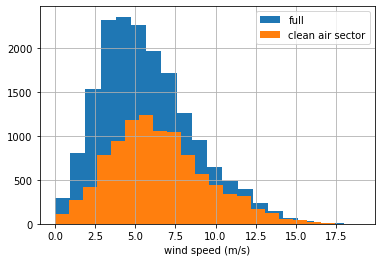

In [9]:
full.wind_speed.hist(bins=20, label='full')
clean.wind_speed.hist(bins=20, label='clean air sector')
plt.xlabel('wind speed (m/s)')
plt.legend()

<h3>Remove low wind speeds less than 3 m/s

In [10]:
clean = clean.loc[clean.wind_speed>3]

Text(0, 0.5, 'CFC-11 (ppt)')

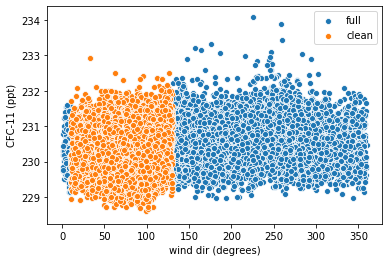

In [10]:
sns.scatterplot(full.wind_dir, full.brw_mr, label='full')
sns.scatterplot(clean.wind_dir, clean.brw_mr, label='clean')
plt.legend()
plt.xlabel('wind dir (degrees)')
plt.ylabel('CFC-11 (ppt)')

,brw_mr,brw_sd,wind_dir,wind_speed
date,,,,
2016-04-01 09:26:00,231.393,0.265,29.5,2.70
2016-04-01 10:26:00,231.387,0.265,49.0,2.95
2016-04-01 12:26:00,231.175,0.267,69.5,4.10
2016-04-01 13:26:00,231.079,0.268,82.0,4.25
2016-04-01 14:25:00,230.879,0.268,76.0,4.45


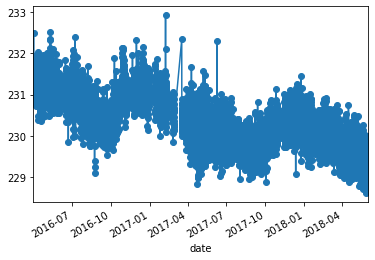

In [11]:
clean.brw_mr.plot(marker='o')
clean.head()

In [12]:
print(f"Number of measurements full:{full.shape[0]} clean:{clean.shape[0]}")

Number of measurements full:17558 clean:9910


<h2>Select random daily sample

In [13]:
df = clean.reset_index()
random.seed(995)
rnd = df.groupby(clean.index.date).apply(lambda x :x.iloc[random.choice(range(0,len(x)), )])

In [14]:
rnd.head()

,date,brw_mr,brw_sd,wind_dir,wind_speed
2016-04-01,2016-04-01 23:24:00,231.583,0.269,65.0,6.25
2016-04-02,2016-04-02 09:23:00,231.417,0.334,59.0,6.65
2016-04-03,2016-04-03 23:18:00,231.080,0.344,82.0,10.25
2016-04-04,2016-04-04 07:17:00,231.368,0.355,87.5,11.40
2016-04-05,2016-04-05 13:14:00,231.290,0.475,86.5,10.00


In [16]:
rnd.set_index(rnd.date, inplace=True)
rnd.drop(['date'], axis=1, inplace=True)
del df

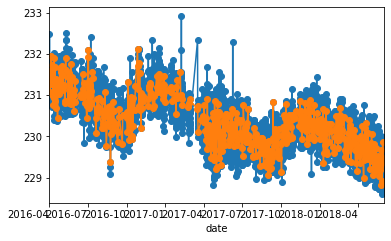

In [15]:
clean.brw_mr.plot(marker='o')
rnd.brw_mr.plot(marker='o')

In [17]:
print(f"Number of measurements full:{full.shape[0]} daily:{rnd.shape[0]}")

Number of measurements full:17558 daily:559


<h2>Select Sunday data between 8-10 GMT or 0-2 local

In [22]:
# clean2 = clean.loc[full.wind_speed>3]
# clean2.reset_index(inplace=True)
# # select hours and weekday
# clean2 = clean2.assign(hh=(clean2.date.dt.hour==8)|(clean2.date.dt.hour==9))
# clean2 = clean2.assign(week=(clean2.date.dt.weekday_name == 'Sunday'))
# clean2 = clean2.loc[(clean2.hh==True)&(clean2.week==True)]

# # if more than one data point, select the first
# clean2 = clean2.assign(dd=clean2.date.diff()>datetime.timedelta(0,4000))
# clean2 = clean2.loc[clean2.dd==True]
# clean2.set_index(clean2.date, inplace=True)
# clean2.drop(['hh','dd','week','date'], axis=1, inplace=True)

In [21]:
# clean.brw_mr.plot(marker='o')
# clean2.brw_mr.plot(marker='o')

In [16]:
full.to_csv('brw-full.csv')
clean.to_csv('brw-clean.csv')
rnd.to_csv('brw-random-daily.csv')